In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression


# 5. PCA

In [40]:
num_imgs = len(os.listdir("preprocessed"))
images = np.empty((num_imgs, 64, 64), dtype=np.uint8)
for i, image in enumerate(sorted(os.listdir("preprocessed"))):
    im = Image.open("preprocessed/" + image)
    images[i,:,:] = np.array(im)

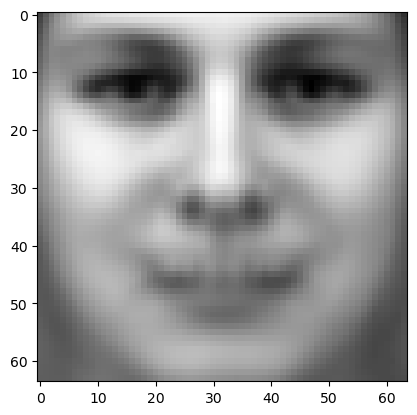

In [41]:
mean_image = images.mean(axis=0)
plt.imshow(mean_image, cmap="gray")
plt.show()

In [42]:
centered = images - mean_image
centered = centered.reshape(centered.shape[0], 64*64)

In [43]:
pca = PCA()
pca.fit(centered)

PCA()

In [44]:
transformed = pca.transform(centered)

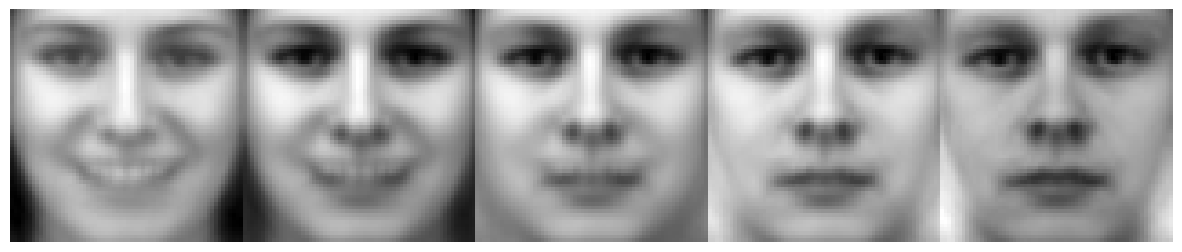

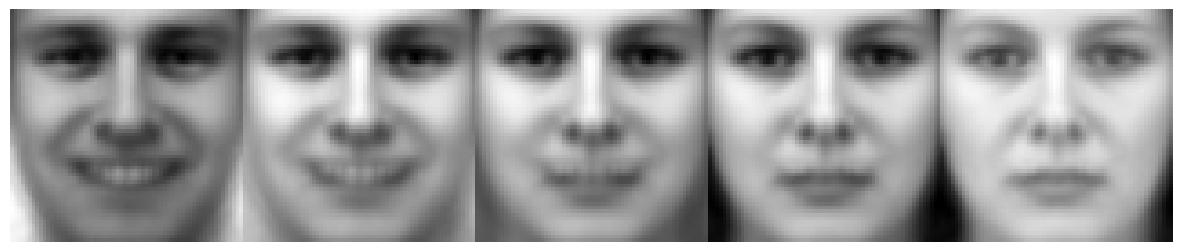

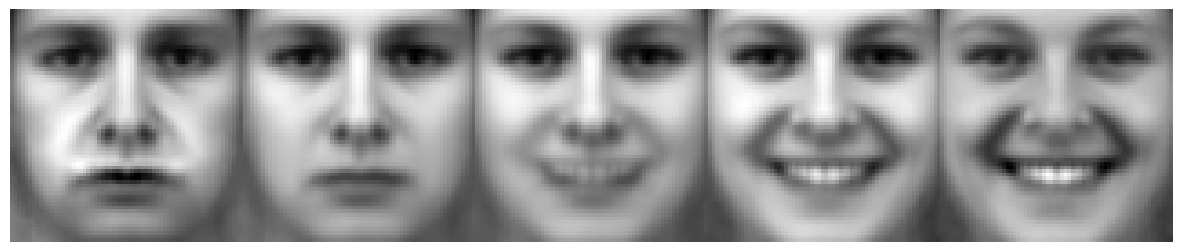

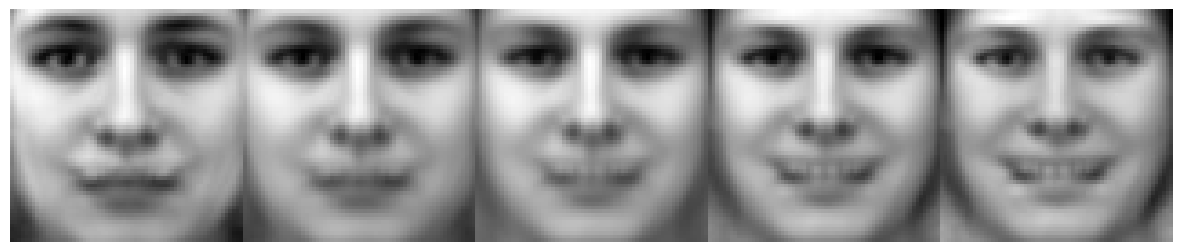

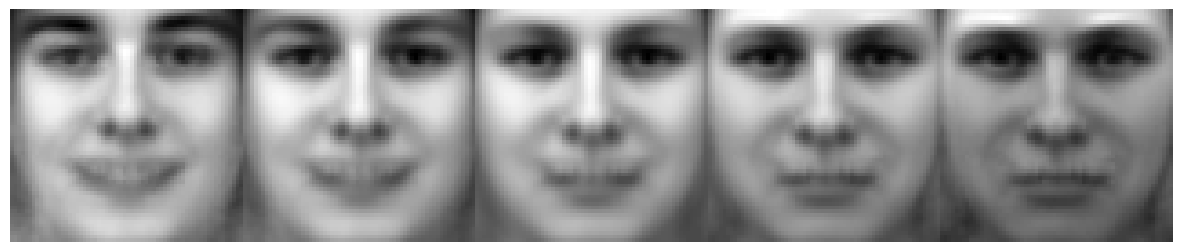

In [45]:
spectrum = 5
pcs = 5

for p in range(pcs):
    max = transformed[:,p].max()
    min = transformed[:,p].min()
    imgs = []
    for i in range(spectrum):
        value = min * (spectrum-1-i) / (spectrum - 1) + max * i / (spectrum - 1)
        vec = np.zeros((396))
        vec[p] = value
        img = pca.inverse_transform(vec).reshape(64,64) + mean_image
        imgs.append(img)
    f, axarr = plt.subplots(1,spectrum, figsize=(15,7))
    plt.subplots_adjust(wspace=0,
                    hspace=0)
    for i in range(spectrum):
        axarr[i].axis('off')
        axarr[i].imshow(imgs[i], cmap="gray")
    plt.show()

In [46]:
exp_var_pca = pca.explained_variance_ratio_
exp_var_pca[:5]

array([0.26343226, 0.14250964, 0.0713695 , 0.05346344, 0.04269085])

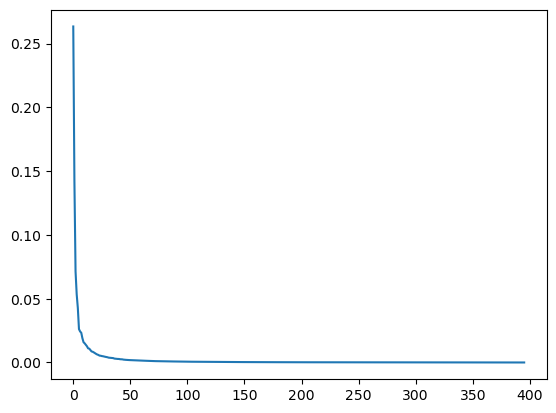

In [62]:
plt.plot(exp_var_pca)
plt.show()

# Feature selection

In [47]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

In [48]:
ratings_df = pd.read_csv("ratings.csv", index_col=0)
ratings_df = ratings_df.sort_values("Image_ID")
ratings_df

aggregate = np.array(ratings_df.iloc[:,[1,2,3]].mean(axis=1))

In [49]:
lin_reg = LinearRegression()



In [57]:
sfs = SequentialFeatureSelector(lin_reg, n_features_to_select= 20, n_jobs = -1, scoring= 'r2')
sfs.fit(transformed, aggregate)

SequentialFeatureSelector(estimator=LinearRegression(), n_features_to_select=20,
                          n_jobs=-1, scoring='r2')

In [58]:
idx = np.where(sfs.get_support())

In [59]:
print(idx)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  11,  12,  16,
        19,  21,  23,  26,  28,  33, 107], dtype=int64),)


In [60]:
len(idx[0])

20

# 7. Linear Model

In [64]:
X = sfs.transform(transformed)
y = aggregate
reg = LinearRegression().fit(X, y)

# 8. Sample generation

In [66]:
delta = reg.intercept_
beta = reg.coef_

In [70]:
ranges_r = np.arange(0, 9)

In [72]:
alfa = (ranges_r - delta)/(np.linalg.norm(beta))**2

In [81]:
generated = alfa* np.repeat(beta, len(alfa)).reshape(len(beta), len(alfa))

In [84]:
generated = generated.T

In [86]:
generated_pca = sfs.inverse_transform(generated)

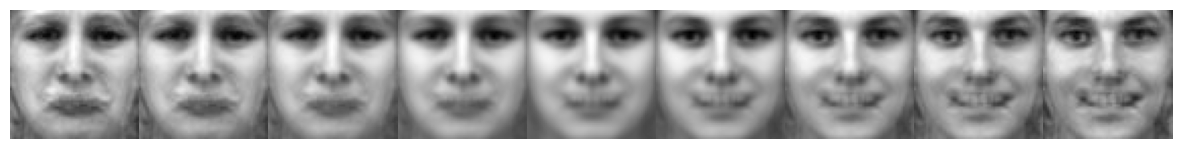

In [95]:
list_img = []
for i,g in enumerate(generated_pca):
    img = pca.inverse_transform(g).reshape(64,64) + mean_image
    Image.fromarray(img).convert("L").save(f'generated/{i}.png', 'PNG')
    list_img.append(img)

f, axarr = plt.subplots(1,9, figsize=(15,7))
plt.subplots_adjust(wspace=0,
            hspace=0)
for i in range(9):
    axarr[i].axis('off')
    axarr[i].imshow(list_img[i], cmap="gray")
plt.show()